<a href="https://colab.research.google.com/github/noelmtv/Colab-Learning/blob/main/Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries#
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
!pip install fredapi



In [ ]:
#define the list of tickers#
tickers = [
    "LEN", "TOL","LGIH","DHI"
]


In [ ]:
#SET THE END DATE TO TODAY#
end_date = datetime.today()

In [ ]:
#Set start date#
start_date = end_date - timedelta(days=10*365)
print(start_date)

2015-01-17 14:09:36.751851


In [ ]:
#download adjusted close prices#
#This is done because you dont want to underweight a stock that pays out dividends#
adj_close_df = pd.DataFrame()
print(adj_close_df.columns)



RangeIndex(start=0, stop=0, step=1)


In [ ]:
# Download the prices for each ticker#
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
print(adj_close_df)

                   LEN         TOL       LGIH         DHI
Date                                                     
2015-01-20   38.380718   30.304943  13.050000   20.574526
2015-01-21   39.233025   30.533142  13.900000   20.986910
2015-01-22   39.740780   30.788733  13.280000   21.237930
2015-01-23   39.650093   30.633556  12.960000   20.708992
2015-01-26   40.701878   31.007793  13.740000   21.856512
...                ...         ...        ...         ...
2025-01-06  135.059998  125.871681  86.889999  139.360001
2025-01-07  133.139999  123.635742  84.650002  137.839996
2025-01-08  133.539993  126.799995  85.870003  139.899994
2025-01-10  129.559998  123.540001  83.290001  136.520004
2025-01-13  131.580002  126.150002  84.449997  138.399994

[2512 rows x 4 columns]


**Step 3: Calculate the Lognormal Returns**

In [ ]:
#Calculate the Lognormal returns for each ticker#
#Use lognormal because the returns are additive#
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [ ]:
#drop missing values#
log_returns = log_returns.dropna()

**Step 4: Calculate the Covariance Matrix**

In [ ]:
#helps us calculate standard deviation/risk in the most optimal way possible#
# MULTIPLY BY 252 TO ANNUALISE THE DAILY RETURNS#

cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           LEN       TOL      LGIH       DHI
LEN   0.131031  0.122322  0.129539  0.112973
TOL   0.122322  0.162574  0.134450  0.114271
LGIH  0.129539  0.134450  0.251168  0.124250
DHI   0.112973  0.114271  0.124250  0.121768


**Section 5: Define portfolio Performance Metrics**

In [ ]:
#calculate the portfolio standard deviation#
def standard_deviation(weights,cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [ ]:
#Calculate Expected Returns using historical returns#
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [ ]:
# calculate the Sharpe Ratio

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)


In [ ]:
# Define your FRED API key
from google.colab import userdata
fred_api_key = userdata.get('fred_api_key')

# Get the risk free rate
from fredapi import Fred
fred = Fred(api_key = fred_api_key)
ten_year_treasury_rate = fred.get_series('GS10')/100

#Set the risk free rate
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)


0.043899999999999995


In [ ]:
#Define the function to minimize (Negative Sharpe Ratio)
# In the case of scipy, there is no direct method to find the maximum value of a function so you gotta flip it.

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

    print(neg_sharpe_ratio)

In [ ]:
#Set the constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = [(0,0.5) for _ in range(len(tickers))]

In [ ]:
#Set the initial weights
initial_weights = np.array([1/len(tickers)] * len(tickers))
print(initial_weights)

[0.25 0.25 0.25 0.25]


In [ ]:
#optimize the weights to maximise the sharpe ratio

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate),
                                 method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = optimized_results.x

# Print the optimized weights
print("Optimized Weights:")
print(optimized_weights)

Optimized Weights:
[0.         0.12809317 0.37190683 0.5       ]


**Analyse the optimal portfolio**

In [ ]:
# Display the analytics of the optimal portfolio

for ticker, weight in zip(tickers, optimized_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimized_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimized_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Optimal Portfolio Return: {optimal_portfolio_return:.4f}")
print(f"Optimal Portfolio Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Optimal Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

LEN: 0.0000
TOL: 0.1281
LGIH: 0.3719
DHI: 0.5000

Optimal Portfolio Return: 0.1837
Optimal Portfolio Volatility: 0.3762
Optimal Sharpe Ratio: 0.3716


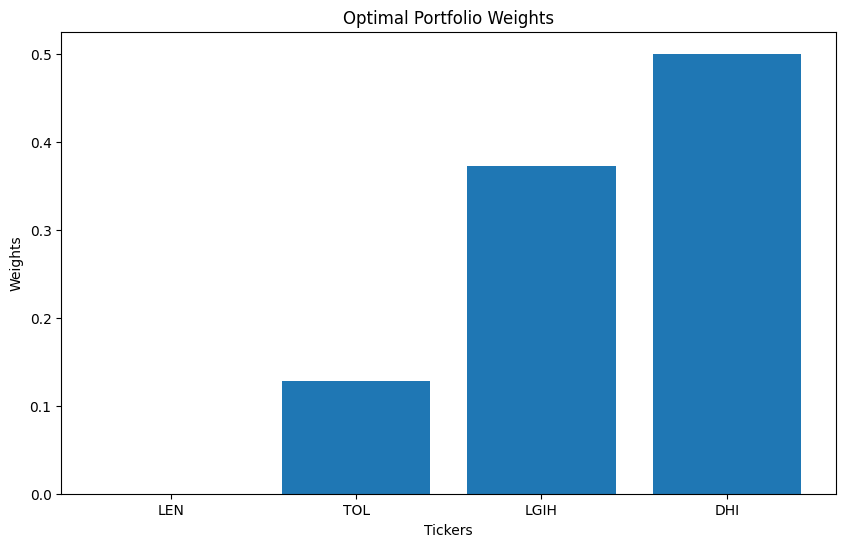

In [ ]:
#display the final portfolio in a plot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimized_weights)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights')
plt.show()